# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [3]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [4]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [ ]:
# Training hyperparameters.
device = 'cuda'
epochs = 100
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import wandb
from datetime import datetime
torch.cuda.is_available()

c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [5]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

In [2]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs, ys = xs.to(device), ys.to(device)
        # Zero out the gradients.
        opt.zero_grad()
        # Forward through the model.
        logits = model(xs) 
        # Compute the cross-entropy loss.
        loss = F.cross_entropy(logits, ys)
        # Backward through the model.
        loss.backward()
        # Update the model parameters.
        opt.step()
        # Save the loss value.
        losses.append(loss.item())
    # Return the average loss for this epoch.
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
            xs = xs.to(device)
            logits = model(xs)
            preds = torch.argmax(logits, 1)
            
            # Save the ground truth and predictions.
            ground_truths.append(ys)
            predictions.append(preds.detach().cpu().numpy())
            
    predictions = np.hstack(predictions)
    ground_truths = np.hstack(ground_truths)
    
    # Return accuracy score and classification report.
    return accuracy_score(ground_truths, predictions), classification_report(ground_truths, predictions, zero_division=0, digits=3, output_dict=True)


def train_model(model, dl_train, dl_val, opt, epochs, model_name, dataset_type, lr, batch_size, device='cpu'):
    wandb.init(
        # set the wandb project where this run will be logged
        project="DLA Assigment 1",
        name=model_name + "-" + datetime.now().strftime("%Y%m%d-%H%M%S"),
        # track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset_type,
            "epochs": epochs,
            "learning_rate": lr,
            "batch_size": batch_size,
            "device": device,
            "optimizer": "Adam"
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss, log="all", log_freq=10)
    losses_and_accs = []
    classification_report = []
    for epoch in range(epochs):
        loss = train_epoch(model, dl_train, opt, epoch, device=device)
        (val_acc, class_rep) = evaluate_model(model, dl_val, device=device)
        losses_and_accs.append((loss, val_acc))
        classification_report.append(class_rep)
        
        print(f'Epoch {epoch}: Loss - {loss:.4f}, Validation Acc - {val_acc:.4f}')
        # wandb
        wandb.log({"epoch": epoch, "loss": loss, "acc": val_acc, "classification_report": class_rep})
                
    # [optional] finish the wandb run, necessary in notebooks
    wandb.unwatch(model)
    wandb.finish()    

    torch.save(model.state_dict(), f"model_states/model_state_{model_name}_{dataset_type}.pt")
    torch.save(model, f"model_states/model_{model_name}_{dataset_type}.pt")

    return losses_and_accs


# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(training_history):
    losses, accuracies = zip(*training_history)
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Average Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title(f'Best Accuracy = {np.max(accuracies)} @ epoch {np.argmax(accuracies)}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(28*28, 128),  # First narrow layer
            nn.Linear(128, 128),  # Second narrow layer
            nn.Linear(128, 64),  # Third narrow layer
            nn.Linear(64, 64), # Fourth narrow layer
            nn.Linear(64, 10)  # Output layer
        ])
    
    def forward(self, x):
        x = x.flatten(1)
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return x

Using device cuda


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lorebaia. Use `wandb login --relogin` to force relogin


Training epoch 0: 100%|██████████| 430/430 [00:30<00:00, 13.94it/s]


Epoch 0: Loss - 1.4166, Validation Acc - 0.8788


Training epoch 1: 100%|██████████| 430/430 [00:23<00:00, 18.66it/s]


Epoch 1: Loss - 0.3584, Validation Acc - 0.9068


Training epoch 2: 100%|██████████| 430/430 [00:23<00:00, 18.41it/s]


Epoch 2: Loss - 0.2916, Validation Acc - 0.9158


Training epoch 3: 100%|██████████| 430/430 [00:23<00:00, 18.42it/s]


Epoch 3: Loss - 0.2593, Validation Acc - 0.9234


Training epoch 4: 100%|██████████| 430/430 [00:23<00:00, 18.42it/s]


Epoch 4: Loss - 0.2339, Validation Acc - 0.9302


Training epoch 5: 100%|██████████| 430/430 [00:24<00:00, 17.80it/s]


Epoch 5: Loss - 0.2129, Validation Acc - 0.9354


Training epoch 6: 100%|██████████| 430/430 [00:23<00:00, 18.68it/s]


Epoch 6: Loss - 0.1965, Validation Acc - 0.9392


Training epoch 7: 100%|██████████| 430/430 [00:23<00:00, 18.53it/s]


Epoch 7: Loss - 0.1802, Validation Acc - 0.9440


Training epoch 8: 100%|██████████| 430/430 [00:22<00:00, 18.75it/s]


Epoch 8: Loss - 0.1668, Validation Acc - 0.9470


Training epoch 9: 100%|██████████| 430/430 [00:23<00:00, 18.64it/s]


Epoch 9: Loss - 0.1551, Validation Acc - 0.9476


Training epoch 10: 100%|██████████| 430/430 [00:22<00:00, 18.72it/s]


Epoch 10: Loss - 0.1434, Validation Acc - 0.9512


Training epoch 11: 100%|██████████| 430/430 [00:22<00:00, 18.85it/s]


Epoch 11: Loss - 0.1349, Validation Acc - 0.9522


Training epoch 12: 100%|██████████| 430/430 [00:23<00:00, 18.59it/s]


Epoch 12: Loss - 0.1248, Validation Acc - 0.9558


Training epoch 13: 100%|██████████| 430/430 [00:22<00:00, 18.70it/s]


Epoch 13: Loss - 0.1166, Validation Acc - 0.9592


Training epoch 14: 100%|██████████| 430/430 [00:23<00:00, 18.51it/s]


Epoch 14: Loss - 0.1086, Validation Acc - 0.9610


Training epoch 15: 100%|██████████| 430/430 [00:23<00:00, 18.64it/s]


Epoch 15: Loss - 0.1027, Validation Acc - 0.9620


Training epoch 16: 100%|██████████| 430/430 [00:23<00:00, 18.67it/s]


Epoch 16: Loss - 0.0958, Validation Acc - 0.9636


Training epoch 17: 100%|██████████| 430/430 [00:23<00:00, 18.50it/s]


Epoch 17: Loss - 0.0902, Validation Acc - 0.9636


Training epoch 18: 100%|██████████| 430/430 [00:22<00:00, 18.77it/s]


Epoch 18: Loss - 0.0850, Validation Acc - 0.9652


Training epoch 19: 100%|██████████| 430/430 [00:23<00:00, 18.55it/s]


Epoch 19: Loss - 0.0800, Validation Acc - 0.9658


acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.9658
epoch,19
loss,0.07999


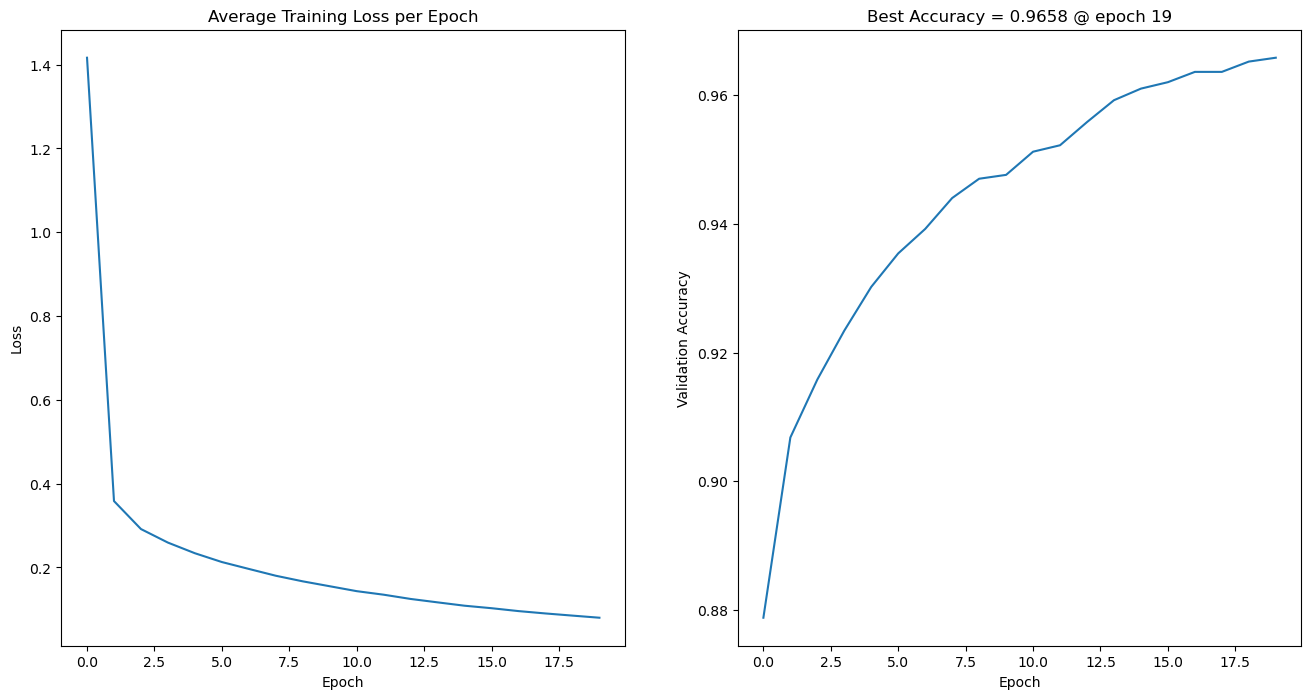

Accuracy report on TEST:
 {'0': {'precision': 0.9632571996027806, 'recall': 0.9897959183673469, 'f1-score': 0.9763462506290891, 'support': 980.0}, '1': {'precision': 0.9841688654353562, 'recall': 0.9859030837004406, 'f1-score': 0.9850352112676056, 'support': 1135.0}, '2': {'precision': 0.9634615384615385, 'recall': 0.9709302325581395, 'f1-score': 0.9671814671814671, 'support': 1032.0}, '3': {'precision': 0.960668633235005, 'recall': 0.9673267326732673, 'f1-score': 0.9639861864824865, 'support': 1010.0}, '4': {'precision': 0.9723926380368099, 'recall': 0.9684317718940937, 'f1-score': 0.9704081632653061, 'support': 982.0}, '5': {'precision': 0.9747126436781609, 'recall': 0.9506726457399103, 'f1-score': 0.9625425652667423, 'support': 892.0}, '6': {'precision': 0.9789695057833859, 'recall': 0.9718162839248434, 'f1-score': 0.9753797799895233, 'support': 958.0}, '7': {'precision': 0.9513822688274547, 'recall': 0.9708171206225681, 'f1-score': 0.9610014443909485, 'support': 1028.0}, '8': {'pre

In [6]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')
epochs = 20
lr = 0.0001
batch_size = 128

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = SimpleMLP().to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training
losses_and_accs = train_model(model_mlp, dl_train, dl_val, opt, epochs, "SimpleMLP", "MNIST", lr, batch_size, device=device)

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [7]:
class NOTRESNET(nn.Module):
    def __init__(self, num_classes=10):
        super(NOTRESNET, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, num_blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
# Define the basic building blocks of ResNet: Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
# The ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_blocks, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64    

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)

        self.layer1 = self._make_layer(ResidualBlock, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, num_blocks[3], stride=2)

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)    # [stride, 1, 1, ...] (num_blocks times) ensures that the first block has stride=stride
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn(self.conv1(x)))       # [batch_size, 3, 32, 32] -> [batch_size, 64, 32, 32]
        out = self.layer1(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 64, 32, 32] (stride=1)
        out = self.layer2(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 128, 16, 16] (stride=2)
        out = self.layer3(out)                     # [batch_size, 128, 16, 16] -> [batch_size, 256, 8, 8] (stride=2)
        out = self.layer4(out)                     # [batch_size, 256, 8, 8] -> [batch_size, 512, 4, 4] (stride=2)
        out = F.avg_pool2d(out, 4)                 # [batch_size, 512, 4, 4] -> [batch_size, 512, 1, 1] (avg_pool2d)
        out = out.view(out.size(0), -1)            # [batch_size, 512, 1, 1] -> [batch_size, 512]
        out = self.fc(out)                         # [batch_size, 512] -> [batch_size, num_classes]
        return out


In [9]:
# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
print(f'Trainset size: {len(trainset)}')
print(f'Testset size: {len(testset)}')

Trainset size: 50000
Testset size: 10000


In [11]:
# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(trainset))
ds_val = Subset(trainset, I[:val_size])
ds_train = Subset(trainset, I[val_size:])

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 128
epochs = 20
learning_rate = 0.00001

dl_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, num_workers=2)
dl_test = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Training epoch 0: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]


Epoch 0: Loss - 1.7637, Validation Acc - 0.4568


Training epoch 1: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]


Epoch 1: Loss - 1.4036, Validation Acc - 0.5428


Training epoch 2: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]


Epoch 2: Loss - 1.2415, Validation Acc - 0.5956


Training epoch 3: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]


Epoch 3: Loss - 1.1270, Validation Acc - 0.6438


Training epoch 4: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]


Epoch 4: Loss - 1.0333, Validation Acc - 0.6732


Training epoch 5: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]


Epoch 5: Loss - 0.9538, Validation Acc - 0.7038


Training epoch 6: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]


Epoch 6: Loss - 0.8806, Validation Acc - 0.7398


Training epoch 7: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]


Epoch 7: Loss - 0.8112, Validation Acc - 0.7624


Training epoch 8: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]


Epoch 8: Loss - 0.7428, Validation Acc - 0.7860


Training epoch 9: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]


Epoch 9: Loss - 0.6784, Validation Acc - 0.8160


Training epoch 10: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]


Epoch 10: Loss - 0.6159, Validation Acc - 0.8496


Training epoch 11: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]


Epoch 11: Loss - 0.5561, Validation Acc - 0.8752


Training epoch 12: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]


Epoch 12: Loss - 0.4931, Validation Acc - 0.8960


Training epoch 13: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]


Epoch 13: Loss - 0.4354, Validation Acc - 0.9194


Training epoch 14: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]


Epoch 14: Loss - 0.3783, Validation Acc - 0.9420


Training epoch 15: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]


Epoch 15: Loss - 0.3286, Validation Acc - 0.9554


Training epoch 16: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]


Epoch 16: Loss - 0.2808, Validation Acc - 0.9740


Training epoch 17: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]


Epoch 17: Loss - 0.2363, Validation Acc - 0.9790


Training epoch 18: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]


Epoch 18: Loss - 0.1997, Validation Acc - 0.9882


Training epoch 19: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]


Epoch 19: Loss - 0.1631, Validation Acc - 0.9928


acc,▁▂▃▃▄▄▅▅▅▆▆▆▇▇▇█████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁
acc,0.9928
epoch,19
loss,0.16309


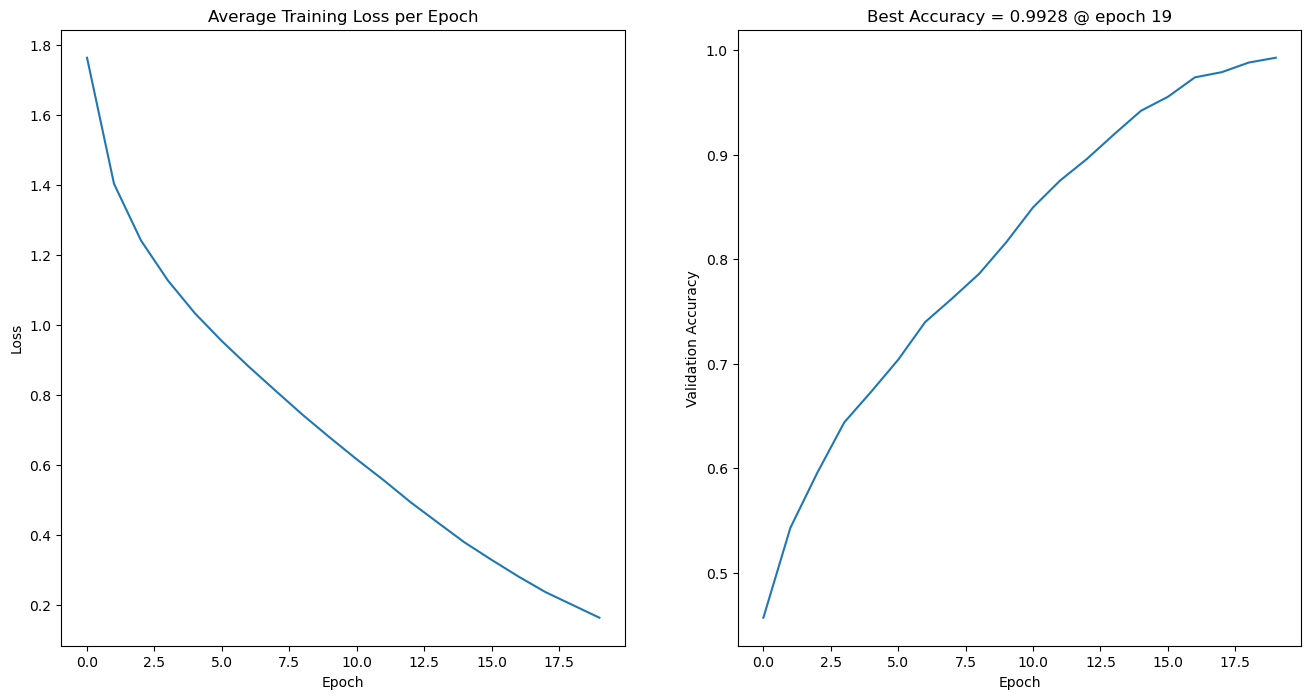

Accuracy report on TEST:
 {'0': {'precision': 0.6708253358925144, 'recall': 0.699, 'f1-score': 0.6846229187071499, 'support': 1000.0}, '1': {'precision': 0.7640562248995983, 'recall': 0.761, 'f1-score': 0.7625250501002004, 'support': 1000.0}, '2': {'precision': 0.5379876796714579, 'recall': 0.524, 'f1-score': 0.5309017223910841, 'support': 1000.0}, '3': {'precision': 0.4022203245089667, 'recall': 0.471, 'f1-score': 0.43390142791340397, 'support': 1000.0}, '4': {'precision': 0.6073059360730594, 'recall': 0.532, 'f1-score': 0.5671641791044776, 'support': 1000.0}, '5': {'precision': 0.497893850042123, 'recall': 0.591, 'f1-score': 0.5404663923182441, 'support': 1000.0}, '6': {'precision': 0.6870300751879699, 'recall': 0.731, 'f1-score': 0.7083333333333334, 'support': 1000.0}, '7': {'precision': 0.765, 'recall': 0.612, 'f1-score': 0.68, 'support': 1000.0}, '8': {'precision': 0.7469635627530364, 'recall': 0.738, 'f1-score': 0.7424547283702213, 'support': 1000.0}, '9': {'precision': 0.7627494

In [13]:
# Initialize the CNN model
NOTRESNET_model = NOTRESNET().to(device)

# Initialize the optimizer
opt = torch.optim.Adam(params=NOTRESNET_model.parameters(), lr=learning_rate)

# Train the model
NOTRESNET_training_history = train_model(NOTRESNET_model, dl_train, dl_val, opt, epochs, "CNN", "CIFAR10", learning_rate, batch_size, device=device)

# Plot the training history
plot_validation_curves(NOTRESNET_training_history)
print(f'Accuracy report on TEST:\n {evaluate_model(NOTRESNET_model, dl_test, device=device)[1]}')

Evaluating:  98%|█████████▊| 39/40 [00:14<00:00,  8.59it/s]c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0: Loss - 1.6518, Validation Acc - 0.5188


Training epoch 1: 100%|██████████| 391/391 [01:58<00:00,  3.29it/s]


Epoch 1: Loss - 1.2527, Validation Acc - 0.6118


Training epoch 2: 100%|██████████| 391/391 [01:58<00:00,  3.29it/s]


Epoch 2: Loss - 1.0347, Validation Acc - 0.7122


Training epoch 3: 100%|██████████| 391/391 [01:58<00:00,  3.29it/s]


Epoch 3: Loss - 0.8295, Validation Acc - 0.8070


Training epoch 4: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


Epoch 4: Loss - 0.6191, Validation Acc - 0.9034


Training epoch 5: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


Epoch 5: Loss - 0.4240, Validation Acc - 0.9572


Training epoch 6: 100%|██████████| 391/391 [01:56<00:00,  3.37it/s]


Epoch 6: Loss - 0.2671, Validation Acc - 0.9818


Training epoch 7: 100%|██████████| 391/391 [01:56<00:00,  3.37it/s]


Epoch 7: Loss - 0.1558, Validation Acc - 0.9936


Training epoch 8: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch 8: Loss - 0.0927, Validation Acc - 0.9988


Training epoch 9: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch 9: Loss - 0.0574, Validation Acc - 0.9996


Training epoch 10: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch 10: Loss - 0.0386, Validation Acc - 1.0000


Training epoch 11: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch 11: Loss - 0.0301, Validation Acc - 1.0000


Training epoch 12: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch 12: Loss - 0.0233, Validation Acc - 1.0000


Training epoch 13: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]


Epoch 13: Loss - 0.0190, Validation Acc - 0.9998


Training epoch 14: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]


Epoch 14: Loss - 0.0168, Validation Acc - 0.9998


Training epoch 15: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]


Epoch 15: Loss - 0.0211, Validation Acc - 0.9968


Training epoch 16: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch 16: Loss - 0.0241, Validation Acc - 0.9976


Training epoch 17: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]


Epoch 17: Loss - 0.0186, Validation Acc - 1.0000


Training epoch 18: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch 18: Loss - 0.0105, Validation Acc - 0.9996


Training epoch 19: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]


Epoch 19: Loss - 0.0102, Validation Acc - 1.0000


acc,▁▂▄▅▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
acc,1.0
epoch,19
loss,0.01025


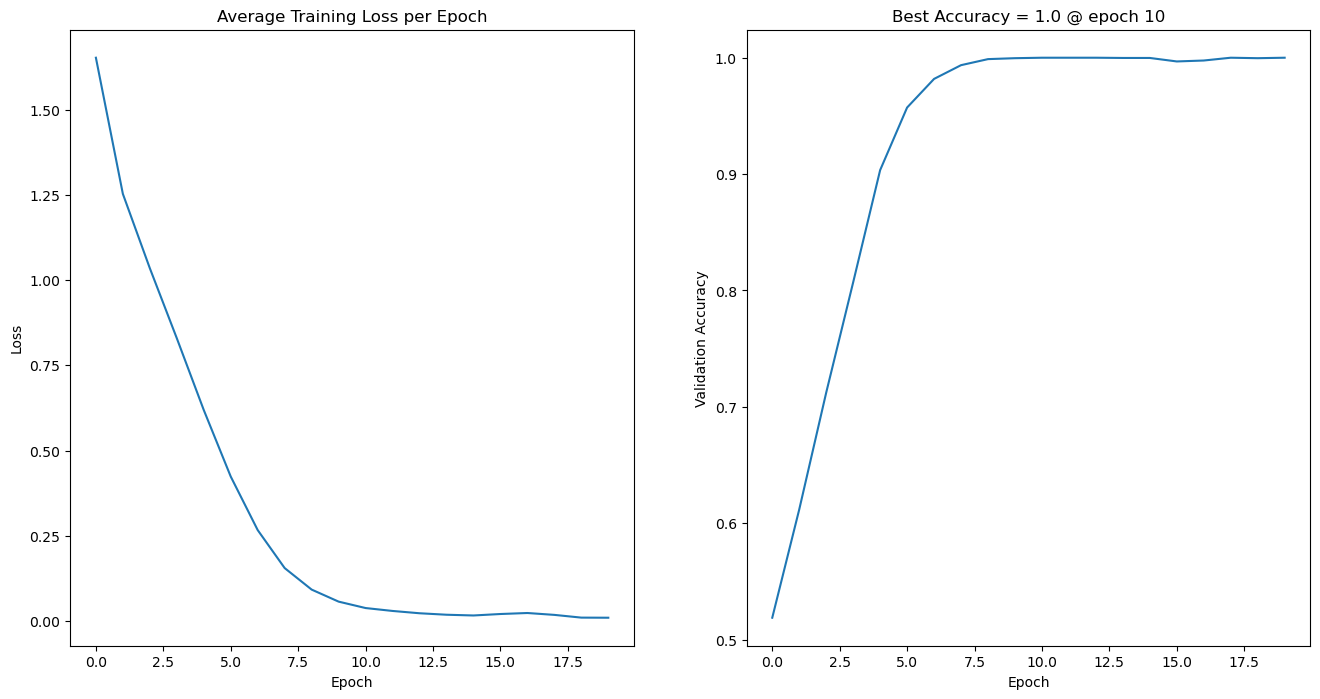

Evaluating:  97%|█████████▋| 77/79 [00:15<00:00, 11.18it/s]c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy report on TEST:
 {'0': {'precision': 0.6737907761529809, 'recall': 0.599, 'f1-score': 0.6341979883536263, 'support': 1000.0}, '1': {'precision': 0.7106854838709677, 'recall': 0.705, 'f1-score': 0.7078313253012049, 'support': 1000.0}, '2': {'precision': 0.49236192714453586, 'recall': 0.419, 'f1-score': 0.45272825499729874, 'support': 1000.0}, '3': {'precision': 0.3778664007976072, 'recall': 0.379, 'f1-score': 0.3784323514727908, 'support': 1000.0}, '4': {'precision': 0.47474747474747475, 'recall': 0.47, 'f1-score': 0.4723618090452261, 'support': 1000.0}, '5': {'precision': 0.4439102564102564, 'recall': 0.554, 'f1-score': 0.4928825622775801, 'support': 1000.0}, '6': {'precision': 0.6355511420059583, 'recall': 0.64, 'f1-score': 0.637767812655705, 'support': 1000.0}, '7': {'precision': 0.6599326599326599, 'recall': 0.588, 'f1-score': 0.6218931782125859, 'support': 1000.0}, '8': {'precision': 0.6847426470588235, 'recall': 0.745, 'f1-score': 0.7136015325670498, 'support': 1000.0}, '

In [14]:
# Initialize the ResNet18 model
resnet18 = ResNet18([2, 2, 2, 2], 10).to(device)

# Define loss function and optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

# Training ResNet18
losses_and_accs = train_model(resnet18, dl_train, dl_val, optimizer, epochs, "ResNet18", "CIFAR10", learning_rate, batch_size, device=device)

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(resnet18, dl_test, device=device)[1]}')

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [96]:
def tot_gradient_magnitudes(model):
    gradient_magnitudes = []
    for param in model.parameters():
        gradient_magnitudes.append(param.grad.abs().mean().item())
    avg_gradient_magnitude = sum(gradient_magnitudes) / len(gradient_magnitudes)
    return avg_gradient_magnitude, gradient_magnitudes

def last_layer_gradient_magnitudes(model):
    gradient_magnitudes = []
    for param in model.fc.parameters():
        gradient_magnitudes.append(param.grad.abs().mean().item())
    avg_gradient_magnitude = sum(gradient_magnitudes) / len(gradient_magnitudes)
    return avg_gradient_magnitude, gradient_magnitudes

In [100]:
# Load the trained models if they are not already loaded
# if not 'resnet18' in locals():
    # resnet18 = ResNet18([2, 2, 2, 2], 10).to(device)
    # resnet18.load_state_dict(torch.load('model_states/model_ResNet18.pt'))
    # resnet18.eval()

# if not 'NOTRESNET_model' in locals():
    # NOTRESNET_model = NOTRESNET().to(device)
    # NOTRESNET_model.load_state_dict(torch.load('model_states/model_CNN.pt'))
    # NOTRESNET_model.eval()

# Calculate gradient magnitudes
avg_gradient_magnitude, gradient_magnitudes = tot_gradient_magnitudes(resnet18)
print(f"ResNet18: Average gradient magnitude: {avg_gradient_magnitude:.4f}")

avg_gradient_magnitude, gradient_magnitudes = last_layer_gradient_magnitudes(resnet18)
print(f"ResNet18: Average gradient magnitude of the last layer: {avg_gradient_magnitude:.4f}")

avg_gradient_magnitude, gradient_magnitudes = tot_gradient_magnitudes(NOTRESNET_model)
print(f"CNN: Average gradient magnitude: {avg_gradient_magnitude:.4f}")

avg_gradient_magnitude, gradient_magnitudes = last_layer_gradient_magnitudes(NOTRESNET_model)
print(f"CNN: Average gradient magnitude of the last layer: {avg_gradient_magnitude:.4f}")

ResNet18: Average gradient magnitude: 0.0048
ResNet18: Average gradient magnitude of the last layer: 0.0049


CNN: Average gradient magnitude: 0.0150
CNN: Average gradient magnitude of the last layer: 0.0142


### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [7]:
class ResNet18FCN(nn.Module):
    def __init__(self, model, num_classes):
        super(ResNet18FCN, self).__init__()
        self.model = model
        # Fully convolutional classification layer
        self.classifier = nn.Conv2d(512, num_classes, kernel_size=1)

        self.classifier.weight.data.copy_( model.fc.weight.data.view ( *model.fc.weight.data.shape, 1, 1))
        self.classifier.bias.data.copy_ (model.fc.bias.data)
    
    def forward(self, x):
        out = F.relu(self.model.bn(self.model.conv1(x)))       # [batch_size, 3, 32, 32] -> [batch_size, 64, 32, 32]
        out = self.model.layer1(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 64, 32, 32] (stride=1)
        out = self.model.layer2(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 128, 16, 16] (stride=2)
        out = self.model.layer3(out)                     # [batch_size, 128, 16, 16] -> [batch_size, 256, 8, 8] (stride=2)
        out = self.model.layer4(out)                     # [batch_size, 256, 8, 8] -> [batch_size, 512, 4, 4] (stride=2)
        out = self.classifier(out)                 # [batch_size, 512, 4, 4] -> [batch_size, num_classes, 4, 4]
        return out

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = ResNet18([2, 2, 2, 2], 10).to(device)
resnet18.load_state_dict(torch.load('model_states/model_ResNet18.pt'))
# Create the fully convolutional model
resnet18_fcn = ResNet18FCN(resnet18, 10).to(device)
resnet18_fcn.eval()

ResNet18FCN(
  (model): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [105]:
# CIFAR10
# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# get labels for CIFAR10
labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Get one image from the test set
image, label = testset[10]
original_image = image.clone()
image = image.unsqueeze(0).to(device)

Files already downloaded and verified


In [106]:
with torch.no_grad():
    outputs = resnet18_fcn(image)
    preds = torch.softmax(outputs, dim=1)
     
    print('Response map shape : ', preds.shape)
 
    # Find the class with the maximum score in the n x m output map
    pred, class_idx = torch.max(preds, dim=1)
    print(class_idx)

    row_max, row_idx = torch.max(pred, dim=1)
    col_max, col_idx = torch.max(row_max, dim=1)
    predicted_class = class_idx[0, row_idx[0, col_idx], col_idx]
     
    # Print top predicted class
    print('Predicted Class : ', labels[predicted_class], predicted_class)

Response map shape :  torch.Size([1, 10, 4, 4])
tensor([[[0, 0, 0, 2],
         [0, 0, 0, 0],
         [0, 0, 3, 3],
         [2, 2, 0, 0]]], device='cuda:0')
Predicted Class :  airplane tensor([0], device='cuda:0')


In [107]:
import cv2 
# Find the n x m score map for the predicted class
score_map = preds[0, predicted_class, :, :].cpu().numpy()
score_map = score_map[0]

# Resize score map to the original image size
score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[2]))
 
# Binarize score map
_, score_map_for_contours = cv2.threshold(score_map, 0.25, 1, type=cv2.THRESH_BINARY)
score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()
 
# Find the countour of the binary blob
contours, _ = cv2.findContours(score_map_for_contours, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
 
# Find bounding box around the object. 
rect = cv2.boundingRect(contours[0])

# Apply score map as a mask to original image
score_map = score_map - np.min(score_map[:])
score_map = score_map / np.max(score_map[:])

score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)

org = original_image.cpu().numpy().transpose(1, 2, 0)
# Move the third channel to the first channel
masked_image = (org * score_map)

In [ ]:
import cv2 

def get_score_map(image, model):
    # Find the n x m score map for the predicted class
    score_map = preds[0, predicted_class, :, :].cpu().numpy()
    score_map = score_map[0]

    # Resize score map to the original image size
    score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[2]))
    
    # Binarize score map
    _, score_map_for_contours = cv2.threshold(score_map, 0.25, 1, type=cv2.THRESH_BINARY)
    score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()
    
    # Find the countour of the binary blob
    contours, _ = cv2.findContours(score_map_for_contours, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    
    # Find bounding box around the object. 
    rect = cv2.boundingRect(contours[0])

    # Apply score map as a mask to original image
    score_map = score_map - np.min(score_map[:])
    score_map = score_map / np.max(score_map[:])

    score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)

    return score_map

In [ ]:
def plot_score_map(original_image, masked_image, score_map, rect):
    # Plot all the results
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(score_map)
    plt.title('Score Map')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(masked_image)
    plt.title('Masked Image')
    plt.axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


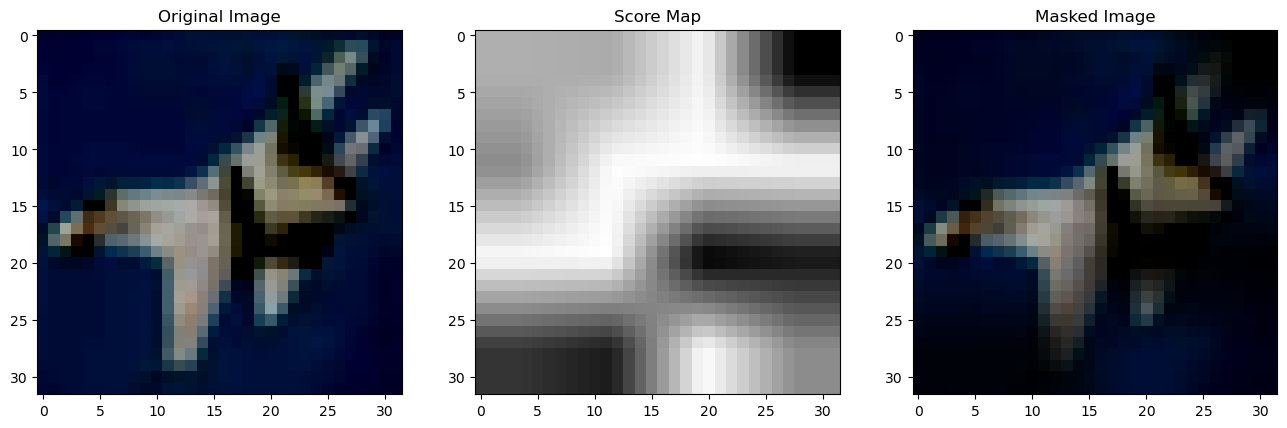

In [108]:
# Plot all the results
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(org)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(score_map)
plt.title('Score Map')

plt.subplot(1, 3, 3)
plt.imshow(masked_image)
plt.title('Masked Image')
plt.show()

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test.
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# get one image from the test set
image, label = ds_test[0]
original_image = image.cpu()
image = image.unsqueeze(0).to(device)

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [35]:
# The ResNet model
class GradCamModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None

        self.layerhook.append(self.model.layer4.register_forward_hook(self.forward_hook()))

        for p in self.model.parameters():
            p.requires_grad = True
        
    def activations_hook(self, grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients
    
    def forward_hook(self):
        def hook(model, input, output):
            self.selected_out = output
            self.tensorhook.append(output.register_hook(self.activations_hook))
        return hook

    def forward(self, x):
        out = self.model(x)
        return out, self.selected_out        

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = ResNet18([2, 2, 2, 2], 10)
resnet18.load_state_dict(torch.load('model_states/model_ResNet18.pt'))
resnet18.eval()

gradcam_model = GradCamModel(resnet18).to(device)

In [95]:
batch_size = 10

# CIFAR10
# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# get one image and label from the test set
image, label = testset[10]
image.unsqueeze_(0).to(device)

Files already downloaded and verified


In [96]:
out, acts = gradcam_model(image)
acts = acts.detach().cpu()

In [97]:
loss = nn.CrossEntropyLoss()(out, torch.tensor([0]).to(device))
loss.backward()

grads = gradcam_model.get_act_grads().detach().cpu()

pooled_grad = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()

for i in range(acts.shape[1]):
    acts[:, i, :, :] *= pooled_grad[i]

In [98]:
import cv2

heatmap = torch.mean(acts, dim=1).squeeze()
heatmap_max = heatmap.max(axis = 0)[0]
heatmap = heatmap / heatmap_max

# Resize heatmap to the original image size
heatmap = cv2.resize(heatmap.numpy(), (original_image.shape[2], original_image.shape[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


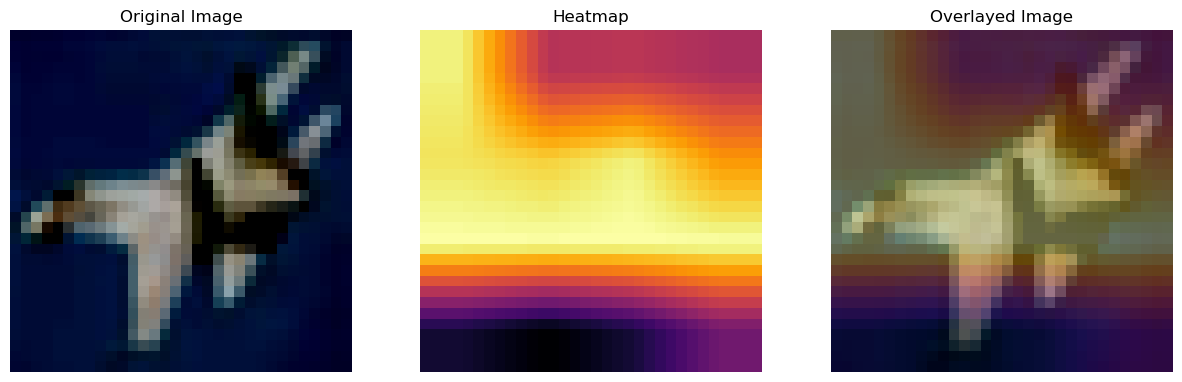

In [99]:
# Plot the original image, heatmap and overlayed image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(original_image.permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='inferno')
plt.title('Heatmap')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(original_image.permute(1, 2, 0))
plt.imshow(heatmap, cmap='inferno', alpha=0.4)
plt.title('Overlayed Image')
plt.axis('off')

plt.show()